In [1]:
import cropper
import dm_den
import dm_den_viz
import math
import paths
import itertools
import pickle
import scipy
import numpy as np
from progressbar import ProgressBar
from importlib import reload
from staudt_utils import print_eq
from astropy import units as u, constants as c
from adjustText import adjust_text

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from matplotlib.lines import Line2D

rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif' 
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.grid'] = False
rcParams['axes.titlesize']=24
rcParams['axes.labelsize']=17
rcParams['axes.titlepad']=15
rcParams['legend.frameon'] = True
rcParams['legend.facecolor']='white'
rcParams['legend.fontsize']=14
rcParams['figure.facecolor']='white'

mls = 11. #marker label size

In [3]:
df = dm_den.load_data('dm_stats_dz1.0_20230724.h5')
df_drop = df.drop(['m12w', 'm12z'])

In [4]:
disp_label = '$\\sigma_\mathrm{DM}\,/\,'\
             '\\left[\mathrm{km\,s^{-1}}\\right]$'
gmr_label = '$\sqrt{Gm/r}\,/\,'\
              '\\left[\mathrm{km\,s^{-1}}\\right]$'
vc_label = '$v_\mathrm{c}\,/\,[\mathrm{km\,s^{-1}}]$'
v_1e4_label = '$\\overline{|v_{\phi,'\
                   '_{T<10^{4}\,\mathrm{K}}}|}'\
                   '\,/\,[\mathrm{km\,s^{-1}}]$'
v_1e3_label = '$\\overline{|v_{\phi,'\
                   '_{T<10^{3}\,\mathrm{K}}}|}'\
                   '\,/\,[\mathrm{km\,s^{-1}}]$'
den_label = '$\\rho_\mathrm{DM}\,/\,\\left[\mathrm{M_\odot kpc^{-3}}\\right]$'

In [11]:
def regress_line(x, reg):
    # Take regression parameters and an x; return the log y value
    return np.log10(10.**reg[1]*x**reg[0][0])

def plt_mw(ax, vcirc, reg):
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    y = regress_line(vcirc, reg)
    ax.vlines(np.log10(vcirc), 
                  ymin=ylim[0],
                  ymax=y)
    ax.hlines(y,
              xmin=xlim[0],
              xmax=np.log10(vcirc))
    ax.set_ylim(*ylim)
    ax.set_xlim(*xlim)
    return None

In [12]:
# v0 ranges from Sofue 2020
v0_sofu=238.
dv0_sofu=14.
log_dv0_neg = np.log10(v0_sofu/(v0_sofu-dv0_sofu))
log_dv0_pos = np.log10((v0_sofu+dv0_sofu)/v0_sofu)

# Density ranges from Sofue 2020
rho_sofu = 0.39*u.GeV/c.c**2.*u.cm**-3.
drho_sofu = 0.09*u.GeV/c.c**2.*u.cm**-3.
rho_sofu = rho_sofu.to(u.M_sun*u.kpc**-3.).value
drho_sofu = drho_sofu.to(u.M_sun*u.kpc**-3.).value
rho_min_sofu = np.log10(rho_sofu-drho_sofu)
rho_max_sofu = np.log10(rho_sofu+drho_sofu)

textxy = (0.04, 0.96)
fontsize = 14

# Dispersion

## First Plot

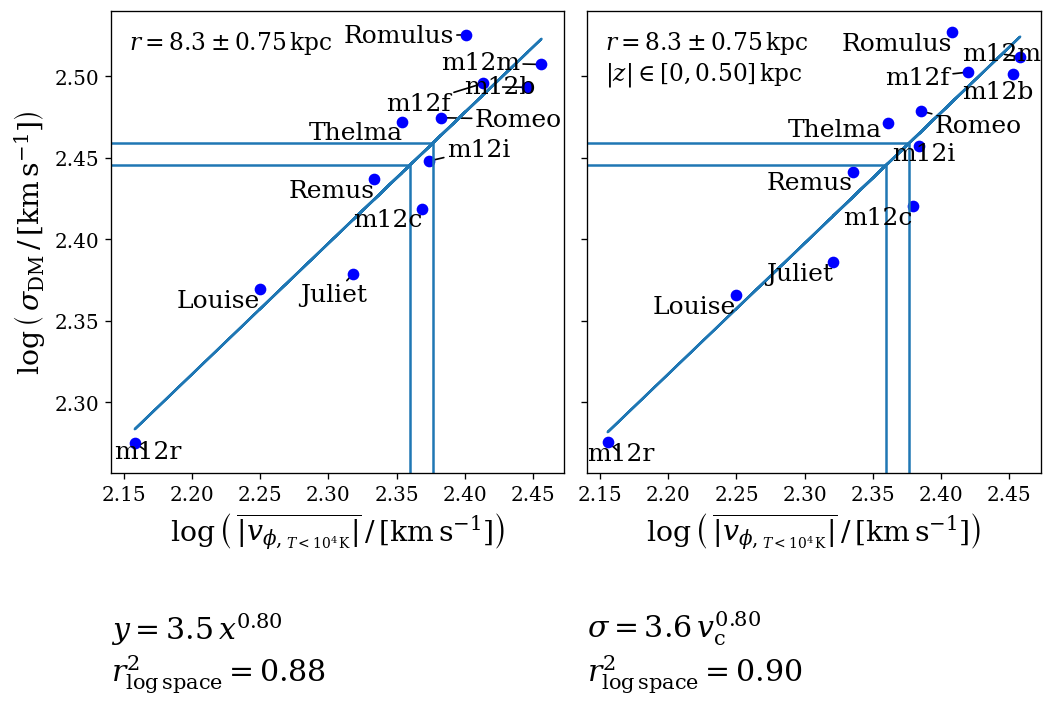

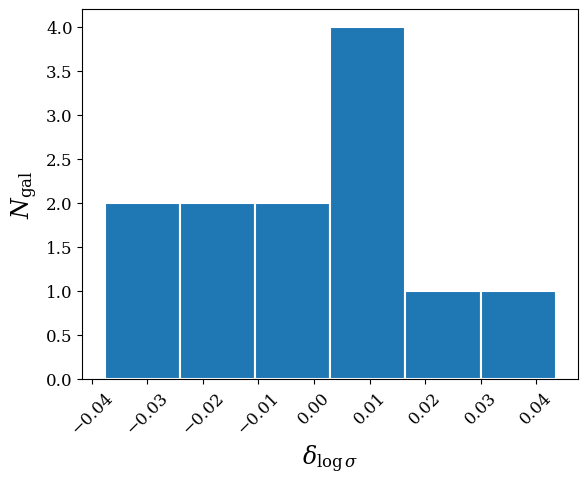

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True,
                        dpi=120)
fig.subplots_adjust(wspace=0.05)
axs = axs.ravel()

reg_shell = dm_den_viz.ax_slr(axs[0], 'dm_stats_20220629.h5',
                              'v_dot_phihat_shell(T<=1e4)',
                              'disp_dm_shell_cyl',
                              xlabel=v_1e4_label,
                              ylabel=disp_label,
                              xadjustment='log', yadjustment='log',
                              formula_y=-0.45, dropgals=['m12w','m12z'],
                              arrowprops={'arrowstyle':'-'})
axs[0].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$'\
                            .format(df.attrs['dr']/2.),
                textxy,
                xycoords='axes fraction', fontsize=fontsize,
                horizontalalignment='left',
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

reg_disc = dm_den_viz.ax_slr(axs[1],'dm_stats_20220629.h5',
                             'v_dot_phihat_disc(T<=1e4)',
                             'disp_dm_disc_cyl',
                             xlabel=v_1e4_label,
                             ylabel=disp_label,
                             xadjustment='log', yadjustment='log',
                             formula_y=-0.45, dropgals=['m12w','m12z'],
                             arrowprops={'arrowstyle':'-'})
axs[1].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$\n'
                '$|z|\in[0,{1:0.2f}]\,\mathrm{{kpc}}$'.format(df.attrs['dr']/2.,
                                                            df.attrs['dz']/2.),
                textxy,
                xycoords='axes fraction', fontsize=fontsize,
                horizontalalignment='left',
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
axs[1].set_ylabel('')

for vcirc in [229., 238.]:
    plt_mw(axs[0], vcirc, reg_shell)
    plt_mw(axs[1], vcirc, reg_disc)

plt.show()


################################################################################
# Errors
################################################################################

df['disp_errors_disc'] = np.log10(df['disp_dm_disc_cyl']) \
                         - regress_line(df['v_dot_phihat_disc(T<=1e4)'], 
                                        reg_disc)

plt.hist(df['disp_errors_disc'].drop(['m12w','m12z']), bins=6, ec='w',
         lw=1.5)
plt.ylabel('$N_\mathrm{gal}$')
plt.xlabel('$\delta_{\log\sigma}$')
plt.xticks(rotation=45)
plt.savefig(paths.figures+'sigma_errors.png',
            bbox_inches='tight',
            dpi=120)
plt.show()

delta_neg = np.percentile(df['disp_errors_disc'], (1.-0.682)/2.*100.)
delta_pos = np.percentile(df['disp_errors_disc'], (1.-(1.-0.682)/2.)*100.)

print_eq('\delta_-',delta_neg,1)
print_eq('\delta_+',delta_pos,1)
print_eq('\delta',np.mean(np.abs((delta_neg, delta_pos))),1)

Evans $\frac{\sigma_\mathrm{3D}}{\mathrm{km/s}}=233\sqrt{3/2}=285.4=10^{2.46}$

In [171]:
df[['disp_errors_disc']].sort_values('disp_errors_disc')

,disp_errors_disc
m12c,-0.040728
Juliet,-0.028214
m12b,-0.019091
m12m,-0.012505
m12i,-0.007107
m12r,-0.006051
Louise,0.008762
m12f,0.008998
Romeo,0.012964
Remus,0.015504


## Checking linear

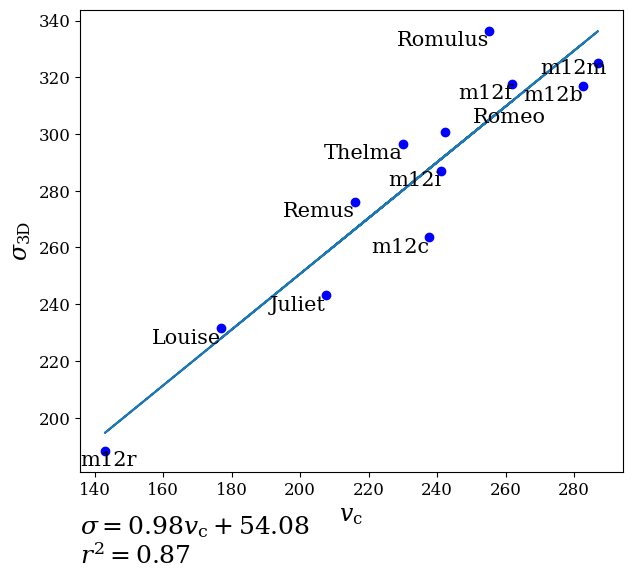

In [18]:
dm_den_viz.plt_slr('dm_stats_dz1.0_20230724.h5',
                   'v_dot_phihat_disc(T<=1e4)',
                   'disp_dm_disc_cyl',
                   '$v_\mathrm{c}$', '$\sigma_\mathrm{3D}$',
                   dropgals=['m12z', 'm12w'])

## Dispersion vs. mass

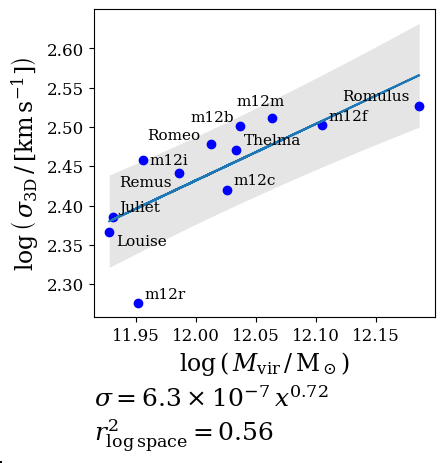

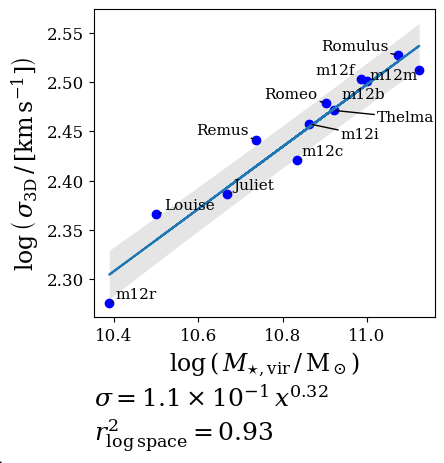

In [9]:
_ = dm_den_viz.plt_slr('dm_stats_20221110.h5',
                   ycol='disp_dm_disc_cyl', xcol='mvir_fromhcat',
                   ylabel=dm_den_viz.disp_label, 
                       xlabel='$M_\mathrm{vir}\,/\,\mathrm{M}_\odot$',
                   xadjustment='log', yadjustment='log', 
                       dropgals=['m12w','m12z'],
                   figsize=(4.4,4.), arrowprops={'arrowstyle':'-'},
                   adjust_text_kwargs={'expand_points':(1.3,1.3)},
                   labelsize=mls, 
                       show_formula=True, formula_y=-0.4,
                       tgt_fname=None, 
                       minarrow=0.04,  
                       ax_slr_kwargs={'show_band':True})

_ = dm_den_viz.plt_slr('dm_stats_20221110.h5',
                   ycol='disp_dm_disc_cyl', xcol='mvir_stellar',
                   ylabel=dm_den_viz.disp_label, 
                       xlabel='$M_\mathrm{\star,vir}\,/\,\mathrm{M}_\odot$',
                   xadjustment='log', yadjustment='log', 
                       dropgals=['m12w','m12z'],
                   figsize=(4.4,4.), arrowprops={'arrowstyle':'-'},
                   adjust_text_kwargs={'expand_points':(1.3,1.3)},
                   labelsize=mls, 
                       show_formula=True, formula_y=-0.4,
                       tgt_fname=None, 
                       minarrow=0.04,  
                       ax_slr_kwargs={'show_band':True})

# Density

## First plot

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

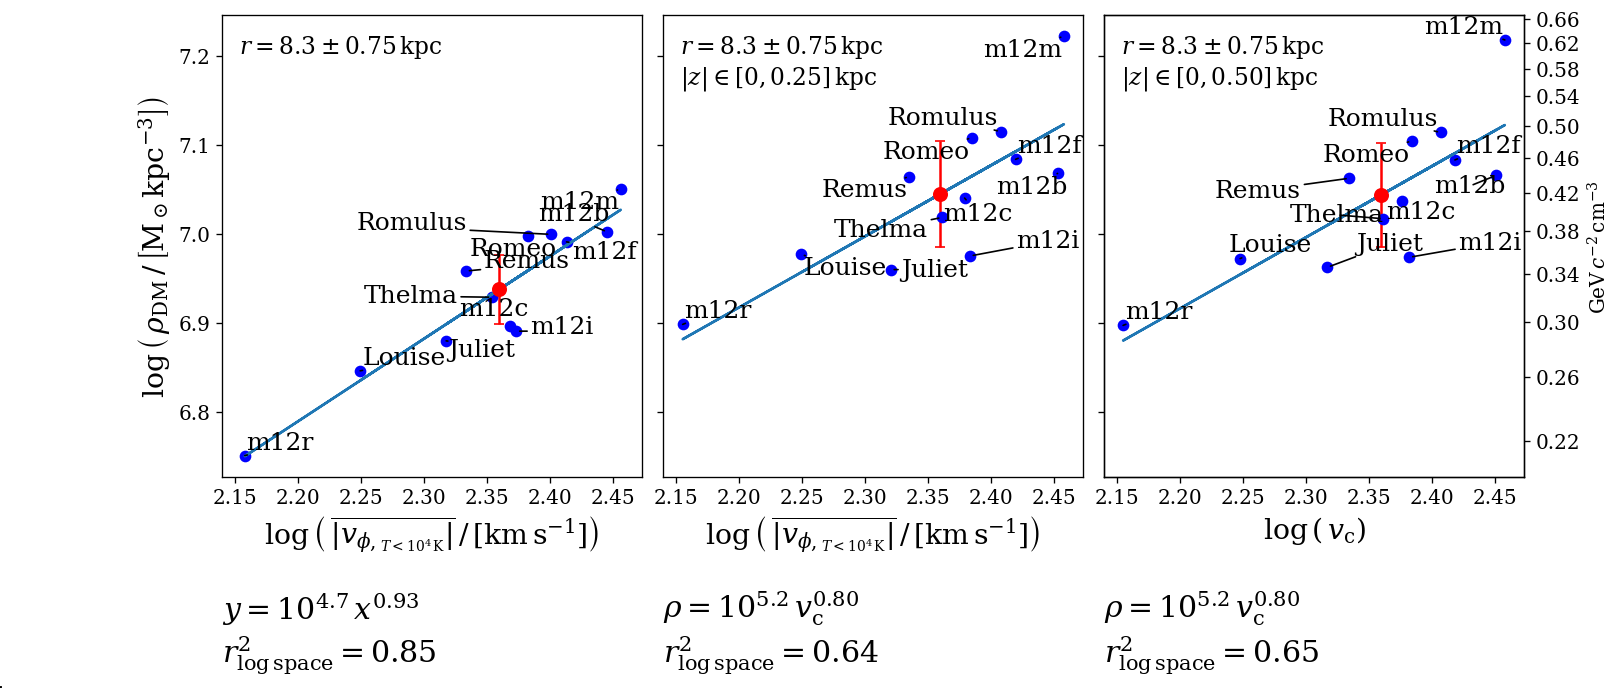

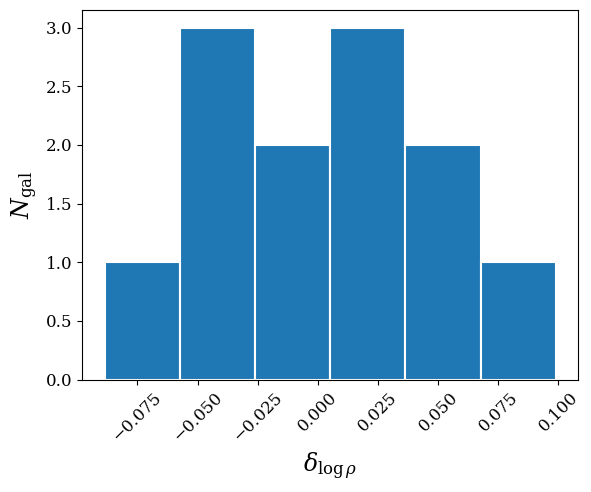

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(14,5), sharey=True, sharex=True,
                        dpi=120)
fig.subplots_adjust(wspace=0.05)
axs = axs.ravel()

reg_shell = dm_den_viz.ax_slr(axs[0], 'dm_stats_20220629.h5',
                              'v_dot_phihat_shell(T<=1e4)',
                              'den_shell',
                              xlabel=v_1e4_label,
                              ylabel=den_label,
                              xadjustment='log', yadjustment='log',
                              formula_y=-0.4, dropgals=['m12w','m12z'],
                              arrowprops={'arrowstyle':'-'},
                              showGeV=False, 
                              x_forecast=[[dm_den_viz.vc_eilers]],
                              dX=[[dm_den_viz.dvc_eilers]])
axs[0].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$'\
                            .format(df.attrs['dr']/2.),
                textxy,
                xycoords='axes fraction', fontsize=fontsize,
                horizontalalignment='left',
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

reg_disc = dm_den_viz.ax_slr(axs[1],'dm_stats_20220629.h5',
                             'v_dot_phihat_disc(T<=1e4)',
                             'den_disc',
                             xlabel=v_1e4_label,
                             ylabel=den_label,
                             xadjustment='log', yadjustment='log',
                             formula_y=-0.4, dropgals=['m12w','m12z'],
                             arrowprops={'arrowstyle':'-'}, showGeV=False,
                             x_forecast=[[dm_den_viz.vc_eilers]],
                             dX=[[dm_den_viz.dvc_eilers]])
axs[1].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$\n'
                '$|z|\in[0,{1:0.2f}]\,\mathrm{{kpc}}$'.format(
                    df.attrs['dr']/2.,
                    df.attrs['dz']/2.),
                textxy,
                xycoords='axes fraction', fontsize=fontsize,
                horizontalalignment='left',
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
axs[1].set_ylabel('')

dm_den_viz.ax_slr(axs[2], 'dm_stats_dz1.0_20230524.h5', 
                  'v_dot_phihat_disc(T<=1e4)',
                  'den_disc',
                  xlabel='$v_\mathrm{c}$',
                  ylabel='',
                  xadjustment='log', yadjustment='log',
                  formula_y=-0.4, dropgals=['m12w','m12z'],
                  arrowprops={'arrowstyle':'-'}, showGev=True,
                  x_forecast=[[dm_den_viz.vc_eilers]],
                  dX=[[dm_den_viz.dvc_eilers]])
# Data taken with dz = 1.0 kpc
df_dz1 = dm_den.load_data('dm_stats_dz1.0_20230524.h5')
axs[2].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$\n'
                '$|z|\in[0,{1:0.2f}]\,\mathrm{{kpc}}$'.format(
                    df_dz1.attrs['dr']/2.,
                    df_dz1.attrs['dz']/2.),
                textxy,
                xycoords='axes fraction', fontsize=fontsize,
                horizontalalignment='left',
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
axs[2].set_ylabel('')
                  

ylim = axs[0].get_ylim()
xlim = axs[0].get_xlim()
    
plt.show()


################################################################################
# Errors
################################################################################
df['den_errors_disc'] = np.log10(df['den_disc']) \
                    - regress_line(df['v_dot_phihat_disc(T<=1e4)'], 
                                   reg_disc)

plt.hist(df['den_errors_disc'].drop(['m12w','m12z']), bins=6, ec='w',
         lw=1.5)
plt.ylabel('$N_\mathrm{gal}$')
plt.xlabel('$\delta_{\log\\rho}$')
plt.xticks(rotation=45)
plt.savefig(paths.figures+'rho_errors.png',
            bbox_inches='tight',
            dpi=120)
plt.show()

delta_neg = np.percentile(df['den_errors_disc'], (1.-0.682)/2.*100.)
delta_pos = np.percentile(df['den_errors_disc'], (1.-(1.-0.682)/2.)*100.)

print_eq('\delta_-',delta_neg,1)
print_eq('\delta_+',delta_pos,1)
print_eq('\delta',np.mean(np.abs((delta_neg, delta_pos))),1)

## Checking linear

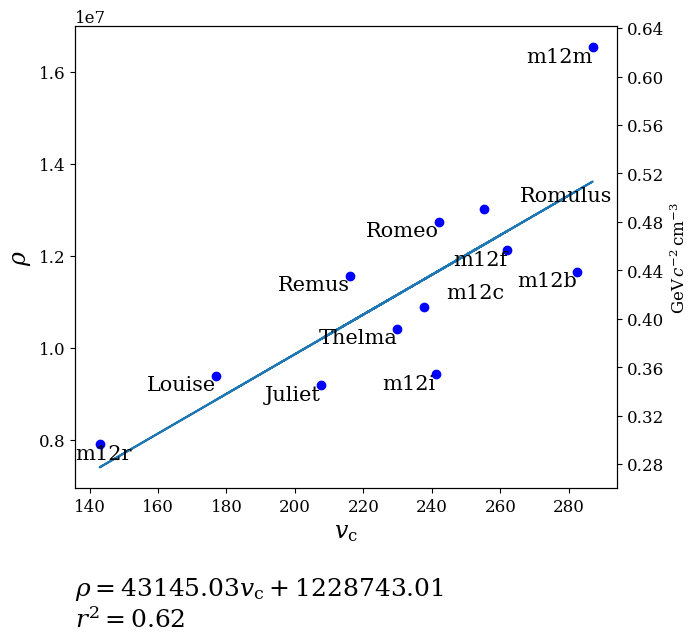

In [28]:
from importlib import reload
reload(dm_den_viz)
dm_den_viz.plt_slr('dm_stats_dz1.0_20230724.h5',
                   'v_dot_phihat_disc(T<=1e4)',
                   'den_disc',
                   '$v_\mathrm{c}$', '$\\rho$',
                   dropgals=['m12z', 'm12w'], formula_y=-0.3)

## Colder Gas

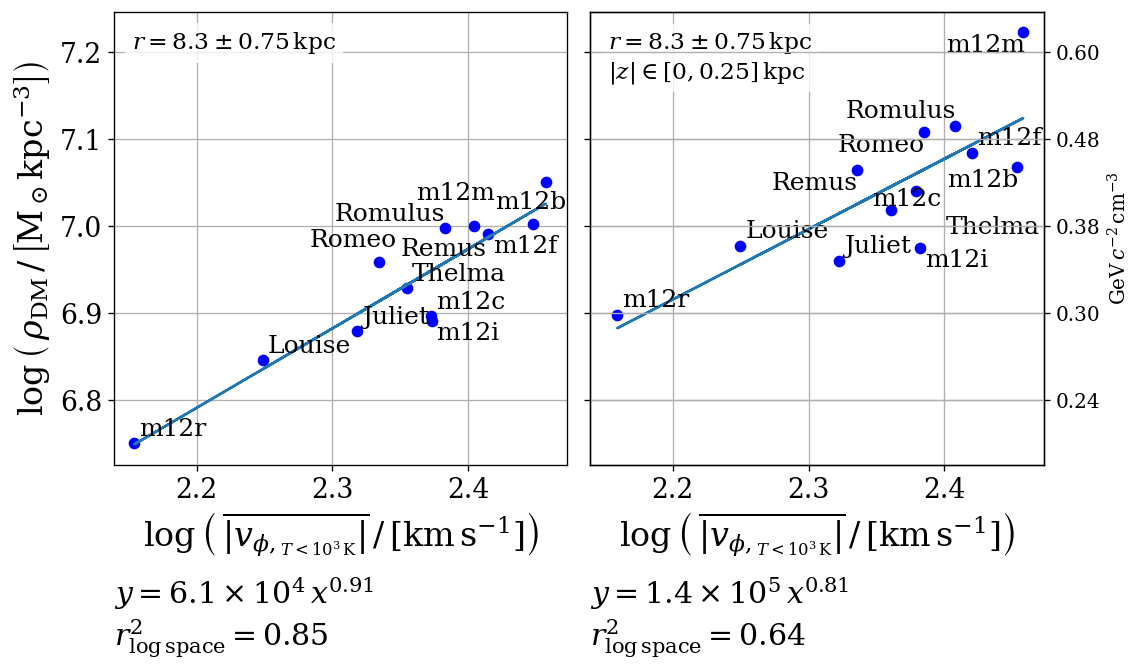

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True, 
                        dpi=120)
fig.subplots_adjust(wspace=0.05)
axs = axs.ravel()

textxy = (0.04, 0.96)
fontsize = 14
dm_den_viz.ax_slr(axs[0], 'dm_stats_20220629.h5',
                   'v_dot_phihat_shell(T<=1e3)',
                   'den_shell',
                   xlabel=v_1e3_label,
                   ylabel=den_label,
                   xadjustment='log', yadjustment='log',
                   formula_y=-0.4, dropgals=['m12w','m12z'],
                   showGeV=False)

dm_den_viz.ax_slr(axs[1],'dm_stats_20220629.h5',
                   'v_dot_phihat_disc(T<=1e3)',
                   'den_disc',
                   xlabel=v_1e3_label,
                   ylabel=den_label,
                   xadjustment='log', yadjustment='log',
                   formula_y=-0.4, dropgals=['m12w','m12z'])

axs[0].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$'.format(df.attrs['dr']/2.),
                textxy,
                xycoords='axes fraction', fontsize=fontsize,
                horizontalalignment='left',
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
axs[1].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$\n'
                '$|z|\in[0,{1:0.2f}]\,\mathrm{{kpc}}$'.format(df.attrs['dr']/2.,
                                                          df.attrs['dz']/2.),
                textxy,
                xycoords='axes fraction', fontsize=fontsize,
                horizontalalignment='left',
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
axs[1].set_ylabel('')
plt.show()

## Density vs. mass

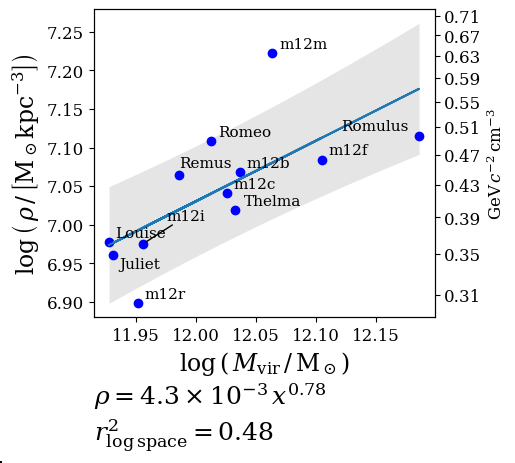

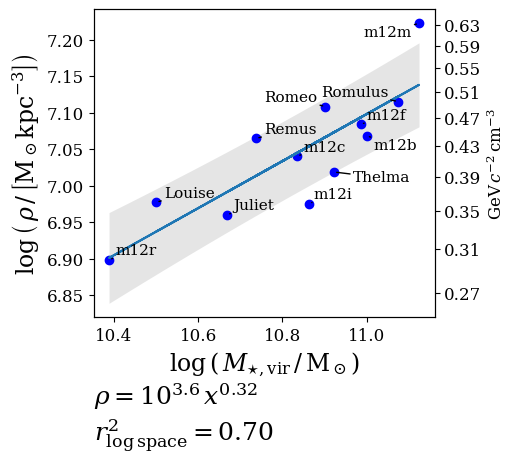

In [7]:
_ = dm_den_viz.plt_slr('dm_stats_20221110.h5',
                   ycol='den_disc', xcol='mvir_fromhcat',
                   ylabel=dm_den_viz.den_label,
                       xlabel='$M_\mathrm{vir}\,/\,\mathrm{M}_\odot$',
                   xadjustment='log', yadjustment='log', 
                       dropgals=['m12w','m12z'],
                   figsize=(4.4,4.), arrowprops={'arrowstyle':'-'},
                   adjust_text_kwargs={'expand_points':(1.3,1.3)},
                   labelsize=mls, 
                       show_formula=True, formula_y=-0.4,
                   tgt_fname=None, minarrow=0.04,  
                       ax_slr_kwargs={'show_band':True})

_ = dm_den_viz.plt_slr('dm_stats_20221110.h5',
                   ycol='den_disc', xcol='mvir_stellar',
                   ylabel=dm_den_viz.den_label, 
                       xlabel='$M_\mathrm{\star,vir}\,/\,\mathrm{M}_\odot$',
                   xadjustment='log', yadjustment='log', 
                       dropgals=['m12w','m12z'],
                   figsize=(4.4,4.), arrowprops={'arrowstyle':'-'},
                   adjust_text_kwargs={'expand_points':(1.3,1.3)},
                   labelsize=mls, 
                       show_formula=True, formula_y=-0.4,
                   tgt_fname=None, minarrow=0.04,  
                       ax_slr_kwargs={'show_band':True})

## Shell vs. Disc Density difference

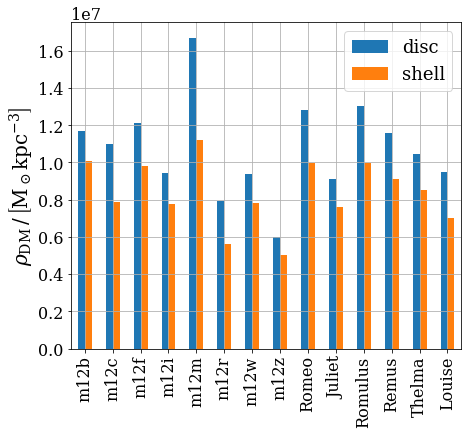

In [9]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
df[['den_disc', 
    'den_shell']].plot.bar(ax=ax)
ax.legend(['disc','shell'])
ax.set_ylabel(den_label)
plt.show()

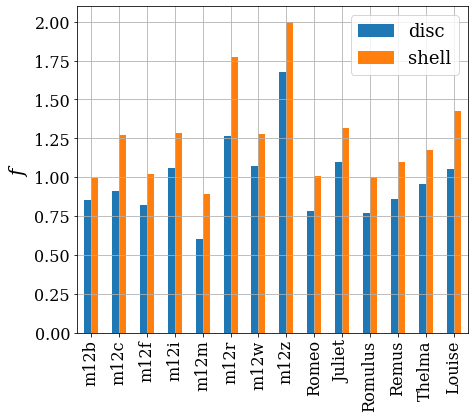

In [10]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
df[['f_disc', 
    'f_shell']].plot.bar(ax=ax)
ax.legend(['disc','shell'])
ax.set_ylabel('$f$')
plt.show()

### Visualizing density vs position
The following plot explains why the average density increases when going from looking at the shell to the disc. Because the density profile is somewhat oblate, as we go from including a variety of $z$'s (constrined to the ring $z^2+x^2=8.3^2$) to only $z=0$, we cross a number of contours and land at a higher average density.

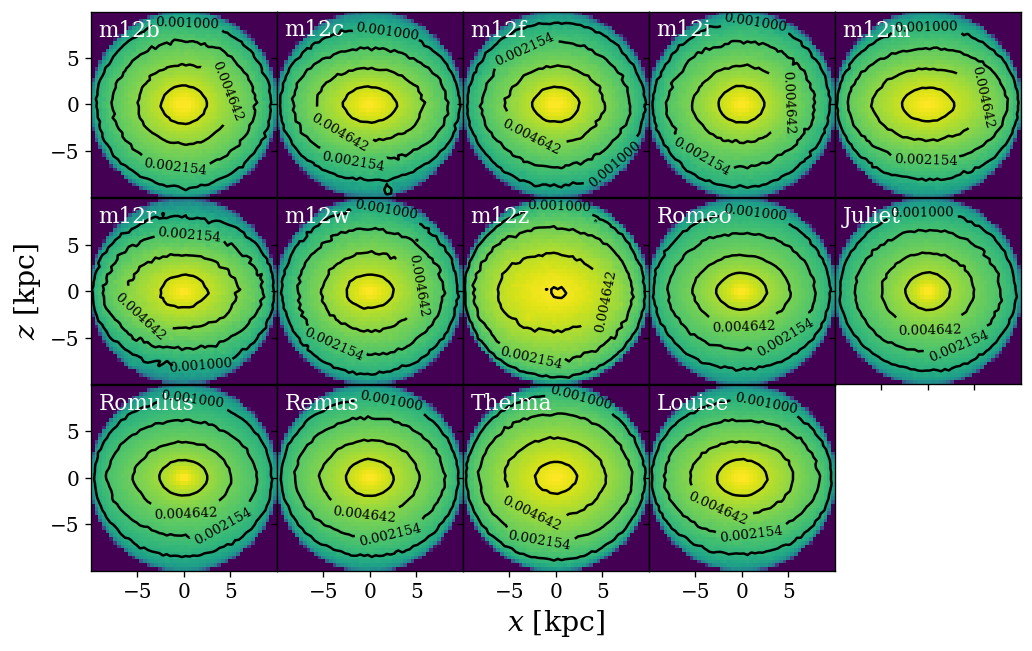

In [7]:
fig,axs = plt.subplots(3, 5, figsize=(10,6*1.01), sharey='row', sharex='col',
                       dpi=120)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
axs[1,0].set_ylabel('$z$ [kpc]')
axs[2,2].set_xlabel('$x$ [kpc]')
axs = axs.ravel()  

for i, galname in enumerate(df.index):
    axs[i].grid(False)
    
    gal = cropper.load_data(galname, ['PartType1'], verbose=False)
    counts,xbins,ybins,image = axs[i].hist2d(gal['PartType1']['coord_rot'][:,0],
                                          gal['PartType1']['coord_rot'][:,2],
                                          bins=int(50), density=True, 
                                          norm=mpl.colors.LogNorm(), 
                                          cmap='viridis')
    CS = axs[i].contour(counts.transpose(),
                    extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                    levels=np.logspace(-3,-2,4), 
                    colors='k')
    axs[i].set_aspect(1)
    axs[i].clabel(CS, inline=True, fontsize=8)
    axs[i].set_facecolor(plt.cm.viridis(0))
    
    axs[i].annotate(galname,
                    (0.04, 0.96),
                    xycoords='axes fraction', fontsize=13,
                    horizontalalignment='left',
                    verticalalignment='top',
                    color='white')
axs[-1].remove()

plt.show()

# Exploring error of the density and dispersion forecasts vs. $v_\mathrm{c}$

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

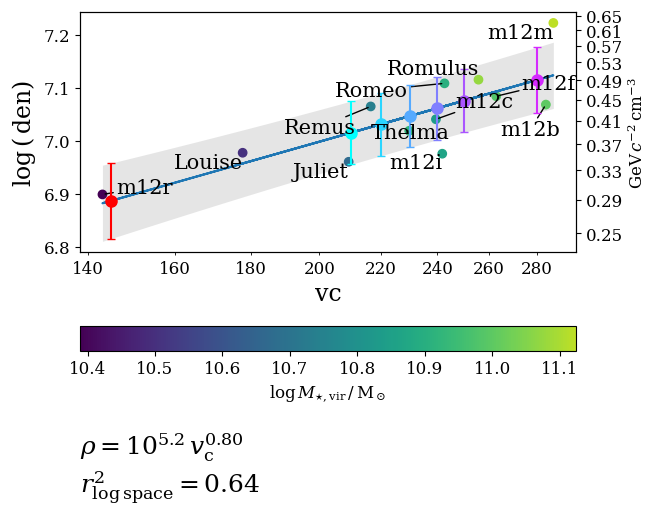

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

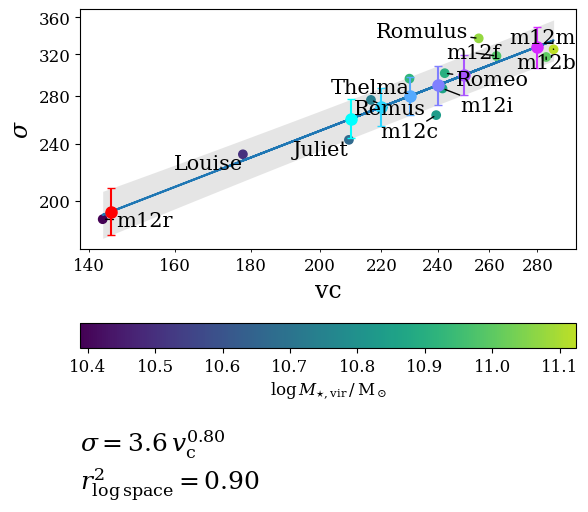

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

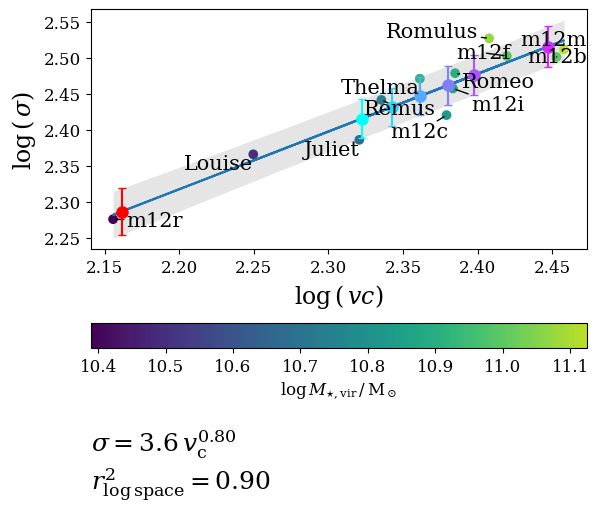

In [91]:
reload(dm_den_viz)
test_xs = [[145.], [210.], [220.], [230.], [240.], 
           [250.], [280.]]

fig = plt.figure()
ax = fig.add_subplot(111)
dm_den_viz.ax_slr(ax, 'dm_stats_20221208.h5',
                  xcol='v_dot_phihat_disc(T<=1e4)',
                  ycol='den_disc',
                  xlabel='vc', ylabel='\mathrm{den}',
                  xadjustment='logreg_linaxunits',
                  yadjustment='log',
                  xscale='log', yscale='linear',
                  formula_y=-1., 
                  dropgals=['m12z', 'm12w'],
                  x_forecast=test_xs,
                  show_band=True, color='masses', #ytickspace=20.,
                  arrowprops={'arrowstyle':'-'})
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
dm_den_viz.ax_slr(ax, 'dm_stats_20221208.h5',
                  xcol='v_dot_phihat_disc(T<=1e4)',
                  ycol='disp_dm_disc_cyl',
                  xlabel='vc', ylabel='$\sigma$',
                  xadjustment='logreg_linaxunits',
                  yadjustment='logreg_linaxunits',
                  xscale='log', yscale='log',
                  formula_y=-1., 
                  dropgals=['m12z', 'm12w'],
                  x_forecast=test_xs,
                  show_band=True, color='masses', ytickspace=40.,
                  arrowprops={'arrowstyle':'-'})
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
dm_den_viz.ax_slr(ax, 'dm_stats_20221208.h5',
                  xcol='v_dot_phihat_disc(T<=1e4)',
                  ycol='disp_dm_disc_cyl',
                  xlabel='vc', ylabel='$\sigma$',
                  xadjustment='log',
                  yadjustment='log',
                  xscale='linear', yscale='linear',
                  formula_y=-1., 
                  dropgals=['m12z', 'm12w'],
                  x_forecast=test_xs,
                  show_band=True, color='masses',
                  arrowprops={'arrowstyle':'-'})
plt.show()

# Dispersion verses density

====  =========  ========  ========  ===========
..        coeff       +/-    t-stat     p-values
====  =========  ========  ========  ===========
X_0   -3.11796   1.40434    4.94699  0.000581121
X_1    0.801854  0.202547   8.82088  4.95605e-06
====  =========  ========  ========  ===========
t_c = 2.2
t-test type: 2 tailed, 5% significance

=======  =======  ==============
      F      F_c    significance
=======  =======  ==============
77.8079  10.0443            0.01
=======  =======  ==============
r2 = 0.89
r2a = 0.87
====  =========  ========  ========  ==========
..        coeff       +/-    t-stat    p-values
====  =========  ========  ========  ==========
X_0   -2.47085   2.39148    2.30209   0.0440975
X_1    0.697818  0.339459   4.58034   0.0010101
====  =========  ========  ========  ==========
t_c = 2.2
t-test type: 2 tailed, 5% significance

=======  =======  ==============
      F      F_c    significance
=======  =======  ==============
20.9795  10.0443            0.01


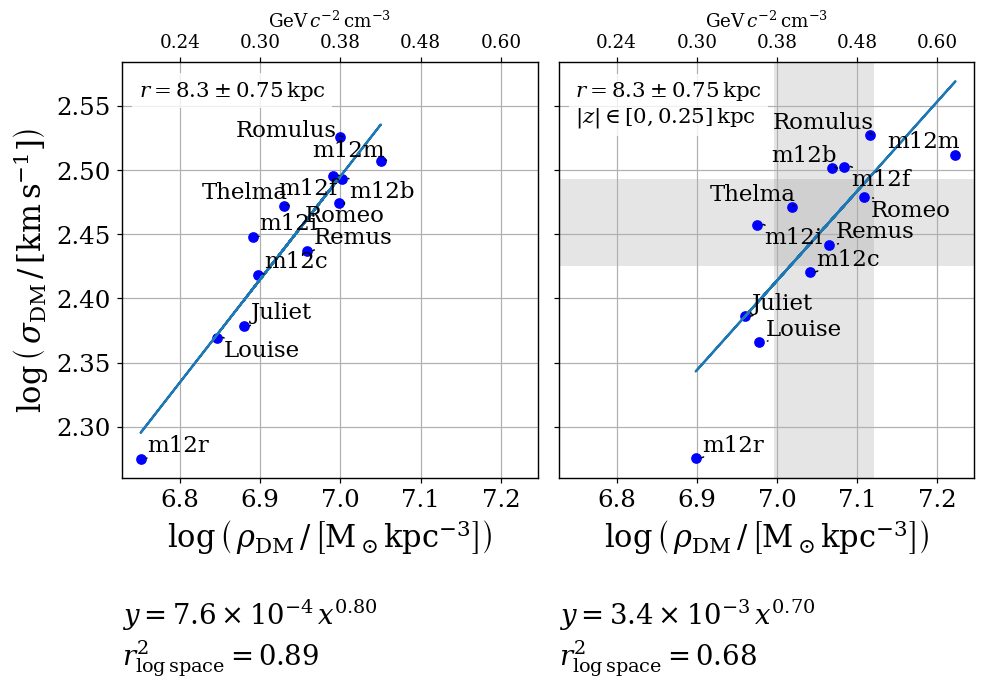

In [219]:
reload(dm_den)
reload(dm_den_viz)

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True, 
                        dpi=110)
fig.subplots_adjust(wspace=0.05)
axs = axs.ravel()

dm_den_viz.ax_slr(axs[0],
                  'dm_stats_20220629.h5', 
                  'den_shell',
                  'disp_dm_shell_cyl',
                  ylabel = disp_label,
                  xlabel = den_label,
                  xadjustment='log', yadjustment='log',
                  dropgals=['m12w','m12z'],
                  formula_y=-0.45, showGeV=False, arrowprops={'arrowstyle':'-'})
dm_den_viz.ax_slr(axs[1],
                  'dm_stats_20220629.h5', 
                  'den_disc',
                  'disp_dm_disc_cyl',
                  ylabel = disp_label,
                  xlabel = den_label,
                  xadjustment='log', yadjustment='log',
                  dropgals=['m12w','m12z'],
                  formula_y=-0.45, showGeV=False, arrowprops={'arrowstyle':'-'})

axs[1].axvspan(den_hat[0]-den_hat[1], 
            den_hat[0]+den_hat[1], 
            alpha=0.2, color='gray', ls='none')
axs[1].axhspan(disp_hat[0]-disp_hat[1],
               disp_hat[0]+disp_hat[1],
               alpha=0.2, color='gray', ls='none')

axs[0].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$'.format(df.attrs['dr']/2.),
                textxy,
                xycoords='axes fraction', fontsize=fontsize,
                horizontalalignment='left',
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
axs[1].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$\n'
                '$|z|\in[0,{1:0.2f}]\,\mathrm{{kpc}}$'.format(df.attrs['dr']/2.,
                                                          df.attrs['dz']/2.),
                textxy,
                xycoords='axes fraction', fontsize=fontsize,
                horizontalalignment='left',
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

axs[1].set_ylabel('')
axs[1].locator_params(axis='x', nbins=6) #Increase the number of ticks
for ax in axs:
    dm_den_viz.showGeV_x(ax, xadjustment='log')

plt.show()

In [40]:
_ = dm_den.mlr('dm_stats_20220629.h5', xcols=['disp_dm_shell_cyl'],
               ycol='den_disc', xscales=['log'], yscale='log',
               dropgals=['m12w','m12z'],
               prediction_x=[10.**disp_hat[0]], dX=[0.], f_sig=0.05)

====  ========  ========  ========  ===========
..       coeff       +/-    t-stat     p-values
====  ========  ========  ========  ===========
X_0   4.60837   1.15519    8.88864  4.62758e-06
X_1   0.997904  0.473014   4.70065  0.000840743
====  ========  ========  ========  ===========
t_c = 2.2
t-test type: 2 tailed, 5% significance

=======  =======  ==============
      F      F_c    significance
=======  =======  ==============
22.0961  10.0443            0.01
=======  =======  ==============
r2 = 0.69
r2a = 0.66

=======  ========
    x_i     coeff
=======  ========
1        4.60837
2.45899  0.997904
=======  ========
=======  =======  =====================  ===============  ==================  ===========
   yhat      t_c    std err of forecast    t_c * std err    dY/dX1 * err(X1)    err(yhat)
=======  =======  =====================  ===============  ==================  ===========
7.06221  2.22814              0.0526271         0.117261                   0     0.117261
======= 

# $v_0$ vs. $v_c$

In [3]:
dm_den.save_v0s(initial_fname = 'dm_stats_20221110.h5',
                new_fname = 'dm_stats_20221208.h5')
df_v0 = dm_den.load_data('dm_stats_20221208.h5')
df_v0

,fsuffix,fsuffix_cropped,res,host_key,mass_class,den_disc,disp_dm_disc_cyl,disp_dm_shell_cyl,v_dot_phihat_disc(T<=1e4),v_dot_phihat_shell(T<=1e4),...,f_shell,f_disc,vcirc,mwithin10,std(v_dot_zhat_disc(dm)),std(v_dot_rhat_disc(dm)),std(v_dot_phihat_disc(dm)),mvir_fromhcat,mvir_stellar,v0
m12b,b,b,7100,host.index,12,1.170129e+07,317.086366,311.367420,283.758511,279.048375,...,0.994396,0.854607,269.145725,6.919590e+10,177.768518,193.410821,177.579198,1.087521e+12,1.000576e+11,306.669617
m12c,c,c,7100,host.index,12,1.097811e+07,263.259099,262.190740,239.454005,233.756358,...,1.268285,0.910904,232.900676,5.378079e+10,134.585601,169.621137,149.735563,1.061268e+12,6.841949e+10,234.530960
m12f,f,f,7100,host.index,12,1.213573e+07,318.089507,313.050024,262.815787,258.971176,...,1.020240,0.824013,252.764832,6.562959e+10,171.164929,196.140206,182.790921,1.273889e+12,9.688680e+10,284.987427
m12i,i,i,7100,host.index,12,9.450796e+06,286.690306,280.495128,241.807572,236.321911,...,1.285353,1.058112,236.371990,5.243655e+10,153.489829,174.220343,168.165027,9.037037e+11,7.304069e+10,261.255127
m12m,m,m,7100,host.index,12,1.668888e+07,324.931984,321.557934,287.058091,285.932526,...,0.890467,0.599201,285.224373,7.244033e+10,172.983928,197.664919,191.274501,1.157137e+12,1.331376e+11,327.646667
m12r,r,r,7100,host.index,12,7.917479e+06,188.632020,188.423635,143.081819,143.913390,...,1.773423,1.263028,153.128805,3.604036e+10,97.832601,115.205367,112.865161,8.952206e+11,2.447281e+10,156.327530
m12w,w,w,7100,host.index,12,9.353585e+06,263.064249,260.999006,129.487160,94.019424,...,1.279753,1.069109,228.696350,5.244644e+10,141.947907,161.627018,151.427533,8.295441e+11,6.662828e+10,246.999329
m12z,z,z,4200,host.index,12,5.966725e+06,203.361145,203.099510,104.352825,104.227662,...,1.998934,1.675961,154.136128,2.842019e+10,109.667360,126.852582,115.053240,6.965137e+11,2.511155e+10,178.951553
Romeo,_elvis_RomeoJuliet,_elvis_Romeo,3500,host.index,12,1.283338e+07,301.077823,298.250291,242.638363,241.303256,...,1.004627,0.779218,246.622044,7.151835e+10,163.690122,183.900866,173.302830,1.028456e+12,7.978963e+10,278.838318
Juliet,_elvis_RomeoJuliet,_elvis_Juliet,3500,host2.index,12,9.124912e+06,243.188073,239.041004,209.268099,207.870346,...,1.318025,1.095901,209.298198,5.341608e+10,132.378418,147.090063,141.353836,8.526029e+11,4.663527e+10,202.339142


## Linear

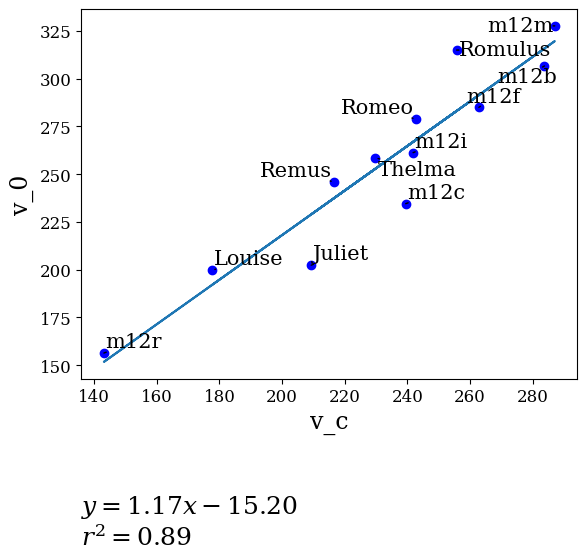

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

dm_den_viz.ax_slr(ax,
                  'dm_stats_20221208.h5', 
                  'v_dot_phihat_disc(T<=1e4)',
                  'v0',
                  ylabel = 'v_0',
                  xlabel = 'v_c',
                  xadjustment=None, yadjustment=None,
                  dropgals=['m12w','m12z'],
                  formula_y=-0.45, showGeV=False, arrowprops={'arrowstyle':'-'})
plt.show()

## Log

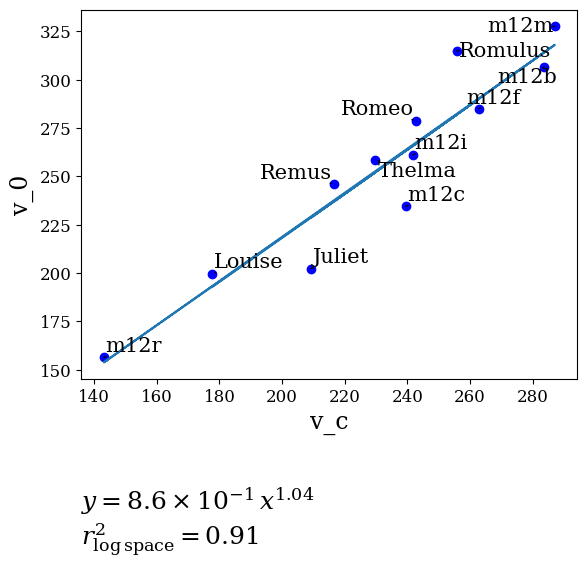

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

dm_den_viz.ax_slr(ax,
                  'dm_stats_20221208.h5', 
                  'v_dot_phihat_disc(T<=1e4)',
                  'v0',
                  ylabel = 'v_0',
                  xlabel = 'v_c',
                  xadjustment='logreg_linaxunits',
                  yadjustment='logreg_linaxunits',
                  dropgals=['m12w','m12z'],
                  formula_y=-0.45, showGeV=False, arrowprops={'arrowstyle':'-'})
plt.show()

# $v_\mathrm{esc}$ vs $v_\mathrm{c}$

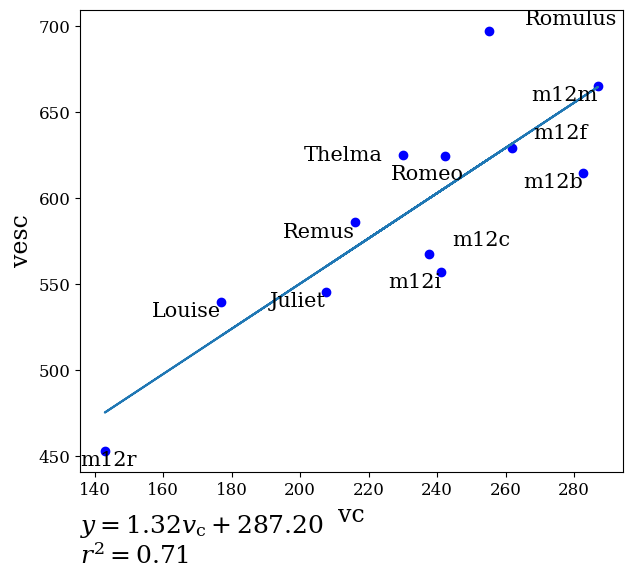

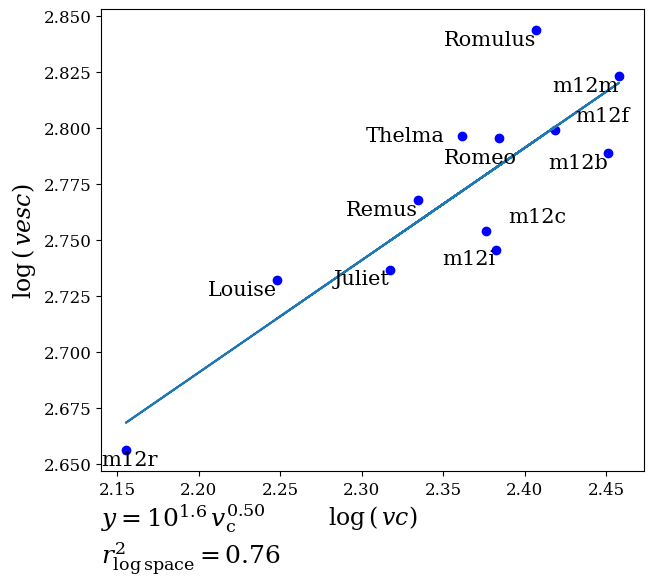

Covariance:
[[ 0.00108919 -0.00289039]
 [-0.00289039  0.00807838]]

====  ========  =========  ========  ===========
..       coeff        +/-    t-stat     p-values
====  ========  =========  ========  ===========
X_0   2.59067   0.0347376  78.4983   2.88658e-15
X_1   0.500895  0.0946041   5.57295  0.000236416
====  ========  =========  ========  ===========
t_c = 1.1
t-test type: 2 tailed, 32% significance

=======  =======  ==============
      F      F_c    significance
=======  =======  ==============
31.0578  10.0443            0.01
=======  =======  ==============
r2 = 0.76
r2a = 0.73


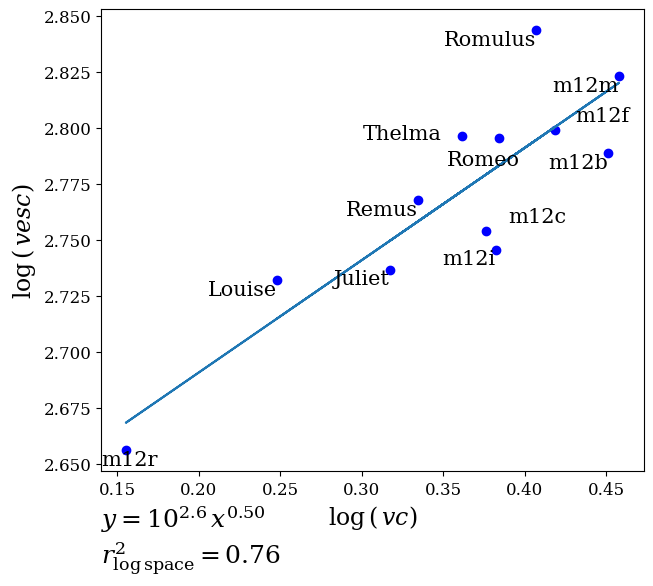

In [11]:
reload(dm_den_viz)
dm_den_viz.plt_slr('dm_stats_dz1.0_20230724.h5', 
                   'v_dot_phihat_disc(T<=1e4)', 
                   'vesc',
                   'vc', 'vesc',
                   dropgals=['m12z', 'm12w'])
dm_den_viz.plt_slr('dm_stats_dz1.0_20230724.h5', 
                   'v_dot_phihat_disc(T<=1e4)', 
                   'vesc',
                   'vc', 'vesc',
                   xadjustment='log', yadjustment='log',
                   dropgals=['m12z', 'm12w'])
dm_den_viz.plt_slr('dm_stats_dz1.0_20230724.h5', 
                   'vc100', 
                   'vesc',
                   'vc', 'vesc',
                   xadjustment='log', yadjustment='log',
                   dropgals=['m12z', 'm12w'], 
                   ax_slr_kwargs=dict(
                       beta_sig=1.-scipy.special.erf(1./np.sqrt(2.)), 
                       verbose=True))

<IPython.core.display.Latex object>

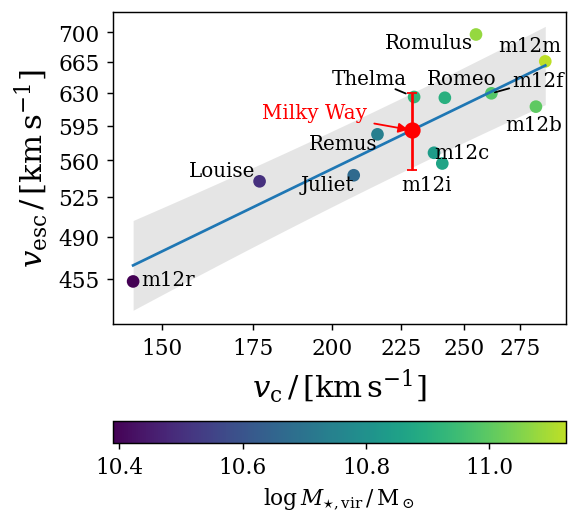

In [8]:
reload(dm_den_viz)
dm_den_viz.plt_vesc_vs_vc('dm_stats_dz1.0_20230724.h5', 
                          tgt_fname='vesc_vs_vc.png',
                          adjust_text_kwargs={#'force_static': (5., 5.),
                                              #'force_text': (0.5, 0.5),
                                              #'force_explode': (.2, .2),
                                              #'explode_radius': 160,
                                              'min_arrow_len': 10.
                                             },
                          formula_y=-1., xtickspace=25., ytickspace=35.,
                          dpi_show=130.,
                          label_overrides={'m12r': (145., 450., False),
                                           'Louise': (157., 545., False),
                                           'm12i': (225., 531., False),
                                           'Romeo': (235., 640., False),
                                           'm12b': (268., 590., False),
                                           'Thelma': (200., 640., True),
                                           'm12m': (265., 678., False)},
                          update_values=True)